(learning)=
# Deep Bayesian predictive coding

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/0.5-Learning.ipynb)

In [1]:
import sys

from IPython.utils import io

if "google.colab" in sys.modules:
    with io.capture_output() as captured:
        ! pip uninstall -y jax jaxlib
        ! pip install pyhgf watermark jax[cuda12]==0.4.31

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import treescope

from pyhgf.model import DeepNetwork, Network

np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

treescope.basic_interactive_setup(autovisualize_arrays=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


```{warning}
The features exposed here are still a work in progress.
```

The hierarchical Gaussian filter is built on top of a generative model that is governed by Gaussian random walks. As such, this model is mostly used to model the time-resolved evolution of beliefs in volatile environments. But the framework can easily extend to traditional applications of predictive coding, such as deep neural networks, where the variational message passing replaces the use of gradient descent during training.

In this notebook, we start from the foundational application of predictive coding networks as a replacement for backpropagation {cite:p}`Song2024` based on **prospective configuration**, where the most likely neural activation is inferred before weight updates. We show that the variational updates that follow the prediction errors can replace prospective configuration based on gradient descent over the energy function of a predictive coding network, and validate this approach on the "bear example" from {cite:p}`Song2024`.

```{figure} https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41593-023-01514-1/MediaObjects/41593_2023_1514_Fig1_HTML.png?as=webp
---
name: task
---
Learning with prospective configuration.

```

## Prospective configuration avoids interference during learning

In [3]:
# here x represents the visual input (River / No River)
x = np.array([1.0, 1.0] * 120)
x += np.random.normal(size=x.shape) / 100

# y represents the auditory and olfactory stimuli
y = np.array([
    x,
    np.concat([
        np.array([1.0, 1.0] * 40),
        np.array([-1.0, -1.0] * 40),
        np.array([1.0, 1.0] * 40),
    ])
    + np.random.normal(size=x.shape) / 100,
]).T

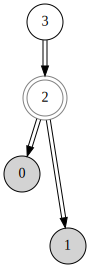

In [4]:
# We start by defining a simple network with two binary branches
network = (
    Network(update_type="unbounded")
    .add_nodes(n_nodes=2, precision=2.0, expected_precision=2.0)
    .add_nodes(
        kind="volatile-node",
        value_children=[0, 1],
        autoconnection_strength=0,
        tonic_volatility=0.0,
        coupling_fn=(jnp.tanh, jnp.tanh),
    )
    .add_nodes(value_children=2, autoconnection_strength=0, coupling_fn=(jnp.tanh,))
)
network.plot_network()

Deep networks trained for classification purposes differ from other predictive coding networks as both roots and leaves should receive inputs (predictors and outcomes, respectively).

In [5]:
network.fit(
    x=x,
    y=y,
    inputs_x_idxs=(3,),
    inputs_y_idxs=(0, 1),
    lr="dynamic",
);

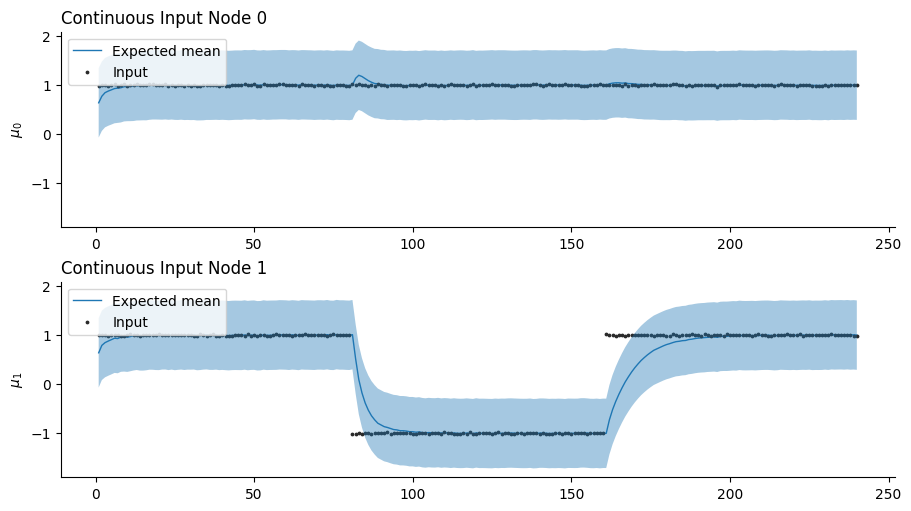

In [6]:
_, axs = plt.subplots(figsize=(9, 5), nrows=2, sharey=True)

network.plot_nodes(0, show_surprise=False, axs=axs[0])
network.plot_nodes(1, show_surprise=False, axs=axs[1])

sns.despine();

This example illustrates the effectiveness of the variational update to replace the prospective configuration step based on gradient descent. As new observations contradict the expected outcomes (i.e., observing the river without hearing the water, from trials 40 to 80 in the bottom panel), the network efficiently reorganizes without interfering with other predictions (i.e,. still expecting smelling the salmon while seeing the water, top panel, trials 40 to 80).

## Controlling the depth of weight updates with input precision

One natural consequence that emerges from this framework is that neural activations are defined by their precision, and as a result, the precision of the inputs (both predictors and outcomes) controls the strengths of prediction errors and the amplitude of weight updates in the vicinity of information flows. For example, more precise outcomes will guide weight updates to be larger at the nodes close to the inputs, and a more precise predictor will guide weight updates to be larger close to the internal representation.

We can simulate this behavior with a deep stack of hidden nodes whose predictors and outcomes differ, which forces the network to reorganize. Here, we show that the balance of precision between predictors and outcomes shapes the depth of weight updates.

In [7]:
def linear(x):
    """Linear activation function."""
    return x

In [8]:
x = np.array([1.0] * 300)
x += np.random.normal(size=x.shape) / 100

y = np.array([0.0] * 300)
y += np.random.normal(size=y.shape) / 100

In [9]:
# We start by defining two networks with varying precision
# at the predictor and outcome levels
high_outcome_precision_network = (
    Network(update_type="unbounded")
    .add_nodes(n_nodes=1, precision=1e2, expected_precision=1e2)
    .add_nodes(
        kind="volatile-node",
        value_children=0,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
    )
    .add_nodes(
        kind="volatile-node",
        value_children=1,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
    )
    .add_nodes(
        kind="volatile-node",
        value_children=2,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
    )
    .add_nodes(
        kind="volatile-node",
        value_children=3,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
        precision=0.1,
        expected_precision=0.1,
    )
)

high_predictor_precision_network = (
    Network(update_type="unbounded")
    .add_nodes(n_nodes=1, precision=0.1, expected_precision=0.1)
    .add_nodes(
        kind="volatile-node",
        value_children=0,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
    )
    .add_nodes(
        kind="volatile-node",
        value_children=1,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
    )
    .add_nodes(
        kind="volatile-node",
        value_children=2,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
    )
    .add_nodes(
        kind="volatile-node",
        value_children=3,
        coupling_fn=(linear,),
        tonic_volatility=-2.0,
        autoconnection_strength=0,
        precision=1e2,
        expected_precision=1e2,
    )
)

In [10]:
high_predictor_precision_network.fit(
    x=x,
    y=y,
    inputs_x_idxs=(4,),
    inputs_y_idxs=(0,),
    lr=0.05,
)
high_outcome_precision_network.fit(
    x=x,
    y=y,
    inputs_x_idxs=(4,),
    inputs_y_idxs=(0,),
    lr=0.05,
);

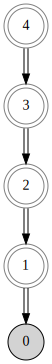

In [11]:
high_outcome_precision_network.plot_network()

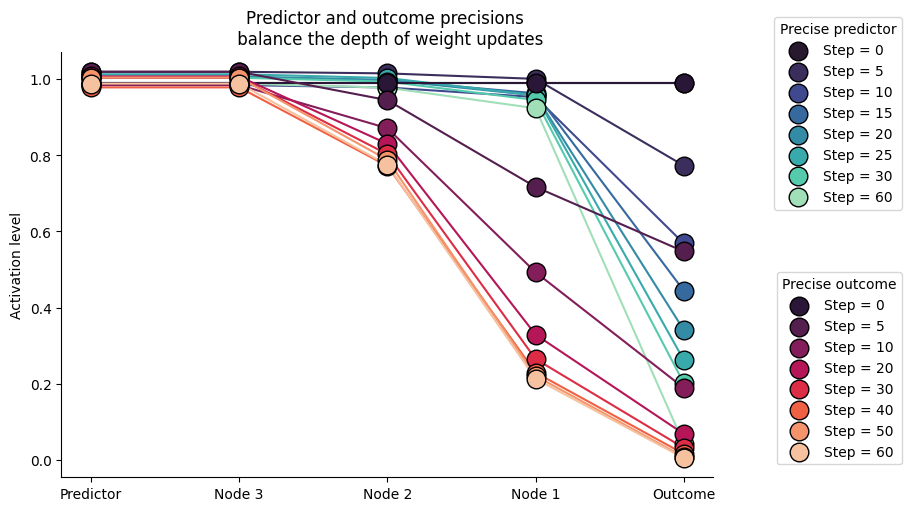

In [12]:
_, ax = plt.subplots(figsize=(9, 5))

# high prediction precision
# -------------------------
palette = sns.color_palette("mako", 8)
handles, labels = [], []
for color, time_step in zip(palette, [0, 5, 10, 15, 20, 25, 30, 60]):
    expected_means = [
        high_predictor_precision_network.node_trajectories[i]["expected_mean"][
            time_step
        ]
        for i in range(5)
    ]
    scatterplot = ax.scatter(
        range(4, -1, -1),
        expected_means,
        s=180,
        color=color,
        label=time_step,
        edgecolor="k",
    )
    handles.append(scatterplot)
    labels.append(f"Step = {time_step}")
    ax.plot(range(4, -1, -1), expected_means, color=color, zorder=-1)

first_legend = ax.legend(
    handles=handles, labels=labels, title="Precise predictor", bbox_to_anchor=(1.3, 1.1)
)
ax.add_artist(first_legend)

# high outcome precision
# ----------------------
palette = sns.color_palette("rocket", 8)
handles, labels = [], []
for color, time_step in zip(palette, [0, 5, 10, 20, 30, 40, 50, 60]):
    expected_means = [
        high_outcome_precision_network.node_trajectories[i]["expected_mean"][time_step]
        for i in range(5)
    ]
    scatterplot = ax.scatter(
        range(4, -1, -1),
        expected_means,
        s=180,
        color=color,
        label=time_step,
        edgecolor="k",
    )
    handles.append(scatterplot)
    labels.append(f"Step = {time_step}")
    ax.plot(range(4, -1, -1), expected_means, color=color, zorder=-1)
second_legend = ax.legend(
    handles=handles, labels=labels, title="Precise outcome", bbox_to_anchor=(1.3, 0.5)
)

plt.xticks(
    ticks=[0, 1, 2, 3, 4], labels=["Predictor", "Node 3", "Node 2", "Node 1", "Outcome"]
)
ax.set(
    ylabel="Activation level",
    title="Predictor and outcome precisions \n balance the depth of weight updates",
)

sns.despine()

## Building Deep-Network Structures in pyhgf

Here, we demonstrate two new high-level functions for constructing layered, fully connected value-parent structures in `pyhgf`:

- **`add_layer()`** – adds a *single* fully connected parent layer.
- **`add_layer_stack()`** – builds *multiple* layers at once, similar to `Sequential` in deep-learning frameworks.

These functions allow HGF models to be composed in a deep-network style while remaining fully compatible with the probabilistic belief-update dynamics.

### Adding Connected Layers with `add_layer`

`add_layer` provides fine-grained control, letting you manually construct each layer.

This is useful when each layer should have different hyperparameters (precision, tonic volatility, autoconnection strength, etc.). The function creates a fully connected parent layer, where all new parent nodes connect to all children below them.

By default, `add_layer` automatically connects to all orphan nodes (nodes without value parents). You can also specify `value_children` explicitly to control which nodes the layer connects to.

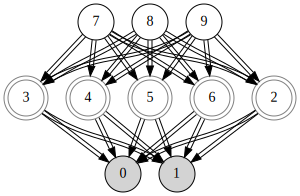

In [13]:
# Or chain them in a single expression (like Keras/PyTorch):
net = (
    DeepNetwork(coupling_fn=(jnp.tanh,))
    .add_nodes(kind="continuous-state", n_nodes=2, precision=5.0)
    .add_layer(size=5, precision=1.0, tonic_volatility=-1.0)
    .add_layer(kind="continuous-state", size=3, precision=0.5, tonic_volatility=-2.0)
)

# Visualize the network structure
net.plot_network()

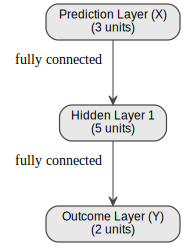

In [14]:
net.plot_deep_network()

In [15]:
# Layer structure information is automatically tracked and can be accessed as needed:
print("Layer structure:", net.layers)
print("Layer sizes:", net.get_layer_sizes())

Layer structure: [[0, 1], [2, 3, 4, 5, 6], [7, 8, 9]]
Layer sizes: [2, 5, 3]


## Adding Multiple Layers with `add_layer_stack`

`add_layer_stack` provides a compact way to build several fully connected parent layers at once. Instead of adding each layer manually, you simply specify the desired layer sizes (e.g., [3, 16, 32]), and the function creates them sequentially. Each layer is fully connected to the one below, using the same hyperparameters for all layers you add (precision, tonic volatility, autoconnection strength, etc.).

This is ideal when you want to quickly prototype deep hierarchical networks or mimic the "stacked layer" construction found in deep learning frameworks.

Like `add_layer`, it also supports method chaining and auto-connects to orphan nodes by default.

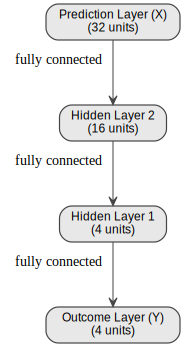

In [16]:
# Add 3 fully connected parent layers (4→4→16→32) using method chaining
net = (
    DeepNetwork()
    .add_nodes(kind="continuous-state", n_nodes=4, precision=5.0)
    .add_layer_stack(
        layer_sizes=[4, 16, 32],
        precision=1.0,
        tonic_volatility=-1.0,
        autoconnection_strength=0.2,
    )
)

net.plot_deep_network()

# System configuration

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Wed, 18 Feb 2026

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.10.0

pyhgf : 0.2.8
jax   : 0.4.31
jaxlib: 0.4.31

IPython   : 9.10.0
jax       : 0.4.31
matplotlib: 3.10.8
numpy     : 2.4.2
platform  : 1.0.8
pyhgf     : 0.2.8
seaborn   : 0.13.2
treescope : 0.1.10

Watermark: 2.6.0

